In [27]:
#1. Significant earthquakes since 2150 B.C.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "D:/ESE5023_Assignments_12532717/PS2/earthquakes-2025-10-29_21-06-00_+0800.tsv"
Sig_Eqs = pd.read_csv(file_path, delimiter='\t')

In [28]:
#1.1
deaths_by_country = Sig_Eqs.fillna({'Total Deaths': 0})
top_10_deaths = deaths_by_country.groupby('Country')['Total Deaths'].sum().sort_values(ascending=False).head(10)

print(top_10_deaths)

Country
CHINA         2106524.0
TURKEY        1008863.0
IRAN           761654.0
SYRIA          487726.0
ITALY          423280.0
HAITI          323782.0
JAPAN          319443.0
AZERBAIJAN     319251.0
INDONESIA      282838.0
ARMENIA        189000.0
Name: Total Deaths, dtype: float64


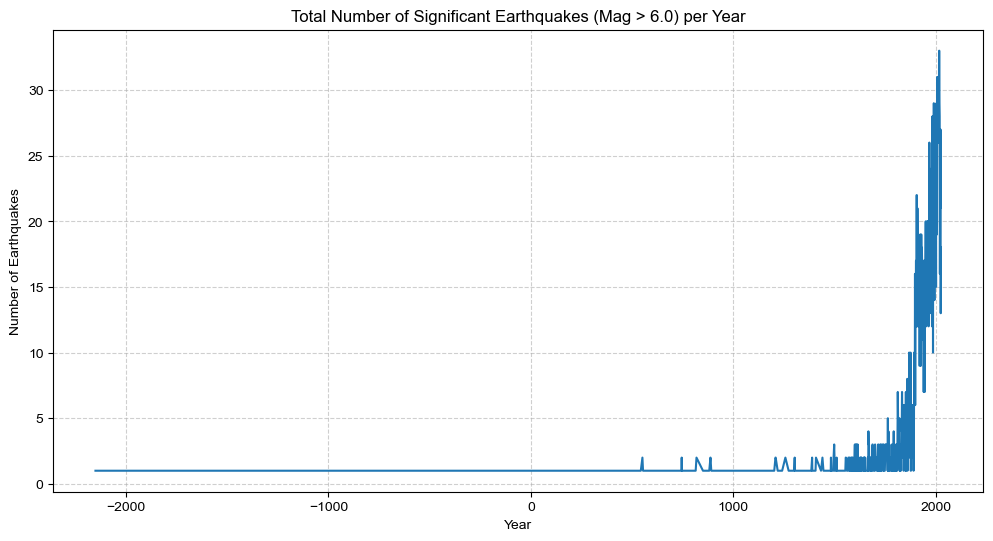

In [29]:
#1.2
filtered_eqs = Sig_Eqs.dropna(subset=['Mag', 'Year'])
mag_gt_6 = filtered_eqs[filtered_eqs['Mag'] > 6.0]
yearly_counts = mag_gt_6.groupby('Year').size()

plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='line')
plt.title('Total Number of Significant Earthquakes (Mag > 6.0) per Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [30]:
# 1.3
def CountEq_LargestEq(country):
    country_data = Sig_Eqs[Sig_Eqs['Country'] == country]
    total_count = len(country_data)
    
    if total_count == 0:
        return 0, "No data", "No data"
    
    # 处理缺失的Mag值
    country_data_mag = country_data.dropna(subset=['Mag'])
    if len(country_data_mag) == 0:
        return total_count, "No magnitude data", "No magnitude data"
    
    # 找到最大震级的地震
    max_mag_idx = country_data_mag['Mag'].idxmax()
    largest_eq = country_data_mag.loc[max_mag_idx]
    max_magnitude = largest_eq['Mag']
    
    # 构建日期，处理缺失的月日
    year = int(largest_eq['Year']) if pd.notna(largest_eq['Year']) else "Unknown"
    
    # 检查是否有月份和日期信息
    has_month = pd.notna(largest_eq['Mo'])
    has_day = pd.notna(largest_eq['Dy'])
    
    if has_month and has_day:
        month = int(largest_eq['Mo'])
        day = int(largest_eq['Dy'])
        date = f"{year}-{month:02d}-{day:02d}"
    elif has_month:
        month = int(largest_eq['Mo'])
        date = f"{year}-{month:02d}"
    else:
        date = f"{year}"
    
    return total_count, date, max_magnitude

# 应用于所有国家并排序
country_stats = {}
for country in Sig_Eqs['Country'].unique():
    if pd.notna(country):  # 过滤掉NaN的国家名
        count, date, mag = CountEq_LargestEq(country)
        country_stats[country] = (count, date, mag)

# 按地震数量降序排序
sorted_countries = sorted(country_stats.items(), key=lambda x: x[1][0], reverse=True)

# 输出前10个结果
print("国家\t\t地震总数\t\t最大地震日期\t最大震级")
print("-" * 60)
for country, (count, date, mag) in sorted_countries[:10]:
    print(f"{country:<15}\t{count:<10}\t{date:<15}\t{mag}")

国家		地震总数		最大地震日期	最大震级
------------------------------------------------------------
CHINA          	623       	1668-07-25     	8.5
JAPAN          	424       	2011-03-11     	9.1
INDONESIA      	421       	2004-12-26     	9.1
IRAN           	388       	856-12-22      	7.9
TURKEY         	358       	1939-12-26     	7.8
ITALY          	333       	1915-01-13     	7.5
GREECE         	289       	365-07-21      	8.0
USA            	280       	1964-03-28     	9.2
PHILIPPINES    	230       	1897-09-21     	8.7
MEXICO         	214       	1787-03-28     	8.6


Text(0.05, 0.95, 'y = 0.00482x + 3.077\np-value: 0.000018')

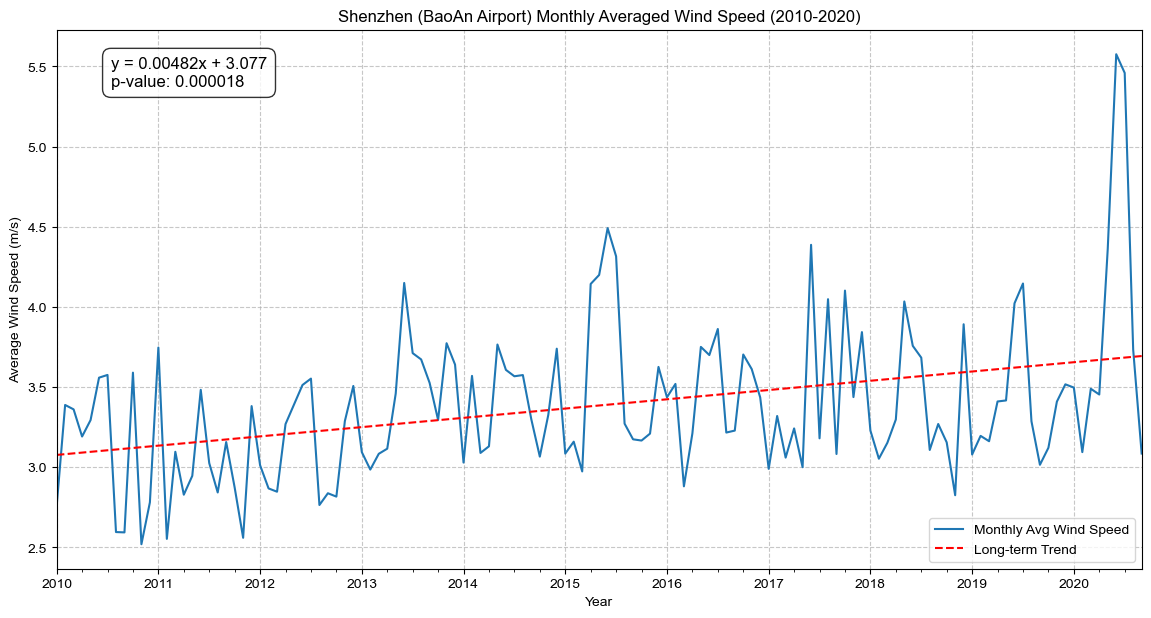

In [31]:
#2. Wind speed in Shenzhen from 2010 to 2020
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'


file_path = '2281305.csv'
df = pd.read_csv(file_path, low_memory=False)
data = df[['DATE', 'WND']].copy()
split_cols = data['WND'].str.split(',', expand=True)
data['WND_SPEED_RAW'] = split_cols[3]
data['WND_QUALITY_RAW'] = split_cols[4]

data['DATETIME'] = pd.to_datetime(data['DATE'], errors='coerce')
data['WND_SPEED'] = pd.to_numeric(data['WND_SPEED_RAW'], errors='coerce')

valid_quality_codes = ['0', '1', '4', '5', '9']
missing_speed_code = 9999
data['WND_SPEED'] = data['WND_SPEED'].replace(missing_speed_code, np.nan)

df_filtered = data[
    (data['WND_QUALITY_RAW'].isin(valid_quality_codes)) &
    (data['WND_SPEED'].notna()) &
    (data['DATETIME'].notna())
].copy()


df_filtered['WIND_MPS'] = df_filtered['WND_SPEED'] / 10.0
df_filtered = df_filtered.set_index('DATETIME')

monthly_avg_wind = df_filtered['WIND_MPS'].resample('ME').mean()


x = np.arange(len(monthly_avg_wind))
y = monthly_avg_wind.values
mask = ~np.isnan(y)
x_fit = x[mask]
y_fit = y[mask]

trend_stats = stats.linregress(x_fit, y_fit)
m, b, p_value = trend_stats.slope, trend_stats.intercept, trend_stats.pvalue

trendline = (m * x) + b
trend_series = pd.Series(trendline, index=monthly_avg_wind.index)

# 格式化字符串
expression_str = f"y = {m:.5f}x + {b:.3f}"
p_value_str = f"p-value: {p_value:.6f}"


plt.figure(figsize=(14, 7))
ax = plt.gca() 

monthly_avg_wind.plot(kind='line', label='Monthly Avg Wind Speed', ax=ax)

trend_series.plot(
    kind='line',
    color='red',
    linestyle='--',
    label='Long-term Trend',
    ax=ax
)


plt.title('Shenzhen (BaoAn Airport) Monthly Averaged Wind Speed (2010-2020)')
plt.xlabel('Year')
plt.ylabel('Average Wind Speed (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

text_to_plot = f"{expression_str}\n{p_value_str}"
plt.text(
    0.05, 0.95, 
    text_to_plot,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)


In [32]:
#3.Explore a data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


FILE_PATH = r"ICESat2_lake_height.csv"
# 使用 pandas 读取 CSV 文件
df = pd.read_csv(FILE_PATH)
print(f"行数 (Rows): {df.shape[0]}")
print(f"列数 (Columns): {df.shape[1]}")
# 显示数据的前5行
print(df.head())
# 显示所有列的名称及其数据类型
print(df.info())

行数 (Rows): 227386
列数 (Columns): 27
   id   Latitude   Longitude      Area     Type  Oct2018     Nov2018  \
0   1  77.912613  -23.634773  0.666206  Natural      NaN         NaN   
1   2  77.892250  -23.822008  0.108693  Natural      NaN  928.545349   
2   3  77.868866  -20.779461  0.315888  Natural      NaN         NaN   
3   4  77.843330 -110.950310  0.598154  Natural      NaN   -3.412109   
4   5  77.831947  -20.891270  0.355333  Natural      NaN         NaN   

      Dec2018     Jan2019   Feb2019  ...     Oct2019     Nov2019   Dec2019  \
0  775.671814         NaN       NaN  ...         NaN  772.795502       NaN   
1         NaN  928.693787       NaN  ...         NaN         NaN       NaN   
2         NaN         NaN       NaN  ...   89.826809         NaN       NaN   
3   -3.328942         NaN -3.199217  ...         NaN         NaN -3.448276   
4         NaN         NaN       NaN  ...  171.002904  170.972336       NaN   

   Jan2020     Feb2020   Mar2020    Apr2020  May2020   Jun2020 

In [33]:
#挑出面积大于10000的数据
df_lakes = df[df['Area'] > 10000]
print(len(df_lakes))
print(df_lakes)

15
            id   Latitude   Longitude           Area       Type      Oct2018  \
95540    95541  66.170349 -123.098793   22622.509073    Natural   142.182180   
142792  142793  61.623337 -114.189430   26039.404469    Natural   126.583547   
149420  149421  60.752140   31.949997   17116.098144  Reservoir    20.877350   
191046  191047  53.086105  -98.453865   24827.936811  Reservoir   184.391208   
193605  193606  52.548405  106.370277   31951.020835  Reservoir   421.951141   
207673  207674  47.537960  -87.010521   70418.379664  Reservoir   146.547105   
208715  208716  46.965714  -91.424416   11451.130547  Reservoir   151.925001   
209353  209354  46.598183   76.393738   16544.870734    Natural   294.276296   
211174  211175  45.478054  -83.532387  116096.987982  Reservoir   140.372534   
213100  213101  43.720364  -77.652008   19230.172780  Reservoir    36.993446   
213962  213963  42.009071  -81.920372   21434.902813    Natural   138.076454   
222417  222418  -1.181953   33.516998

In [34]:
#3.1 
id_cols = ['id', 'Latitude', 'Longitude', 'Area', 'Type']
month_cols = df_lakes.columns.drop(id_cols)

df_cleaned = df_lakes.copy()
df_cleaned[month_cols] = df_cleaned[month_cols].apply(pd.to_numeric, errors='coerce')

null_before = df_cleaned[month_cols].isnull().sum().sum()
print(f"转换为数字格式后，所有月份列中总共有 {null_before} 个 NaN 值。")

# 1. 执行线性插值 
df_cleaned[month_cols] = df_cleaned[month_cols].interpolate(method='linear', axis=1)
print("线性插值完成。")

# 2. 填补边缘 
df_cleaned[month_cols] = df_cleaned[month_cols].bfill(axis=1)


print("边缘填充完成。")

null_after = df_cleaned[month_cols].isnull().sum().sum()
print(f"插值和边缘填充后，所有月份列中剩余 {null_after} 个 NaN 值。")

print("插值后数据预览 (df_cleaned):")
print(df_cleaned.head())

转换为数字格式后，所有月份列中总共有 25 个 NaN 值。
线性插值完成。
边缘填充完成。
插值和边缘填充后，所有月份列中剩余 0 个 NaN 值。
插值后数据预览 (df_cleaned):
            id   Latitude   Longitude          Area       Type     Oct2018  \
95540    95541  66.170349 -123.098793  22622.509073    Natural  142.182180   
142792  142793  61.623337 -114.189430  26039.404469    Natural  126.583547   
149420  149421  60.752140   31.949997  17116.098144  Reservoir   20.877350   
191046  191047  53.086105  -98.453865  24827.936811  Reservoir  184.391208   
193605  193606  52.548405  106.370277  31951.020835  Reservoir  421.951141   

           Nov2018     Dec2018     Jan2019     Feb2019  ...     Oct2019  \
95540   143.606663  142.518844  143.242034  143.835225  ...  142.839623   
142792  127.078623  127.541004  127.211344  127.163485  ...  127.108449   
149420   19.895657   19.942883   20.431718   21.033176  ...   20.076752   
191046  184.288714  184.278557  185.391982  187.286412  ...  184.775945   
193605  418.897403  419.534525  419.740347  417.782043  ..

准备为 5 个湖泊绘制图表...


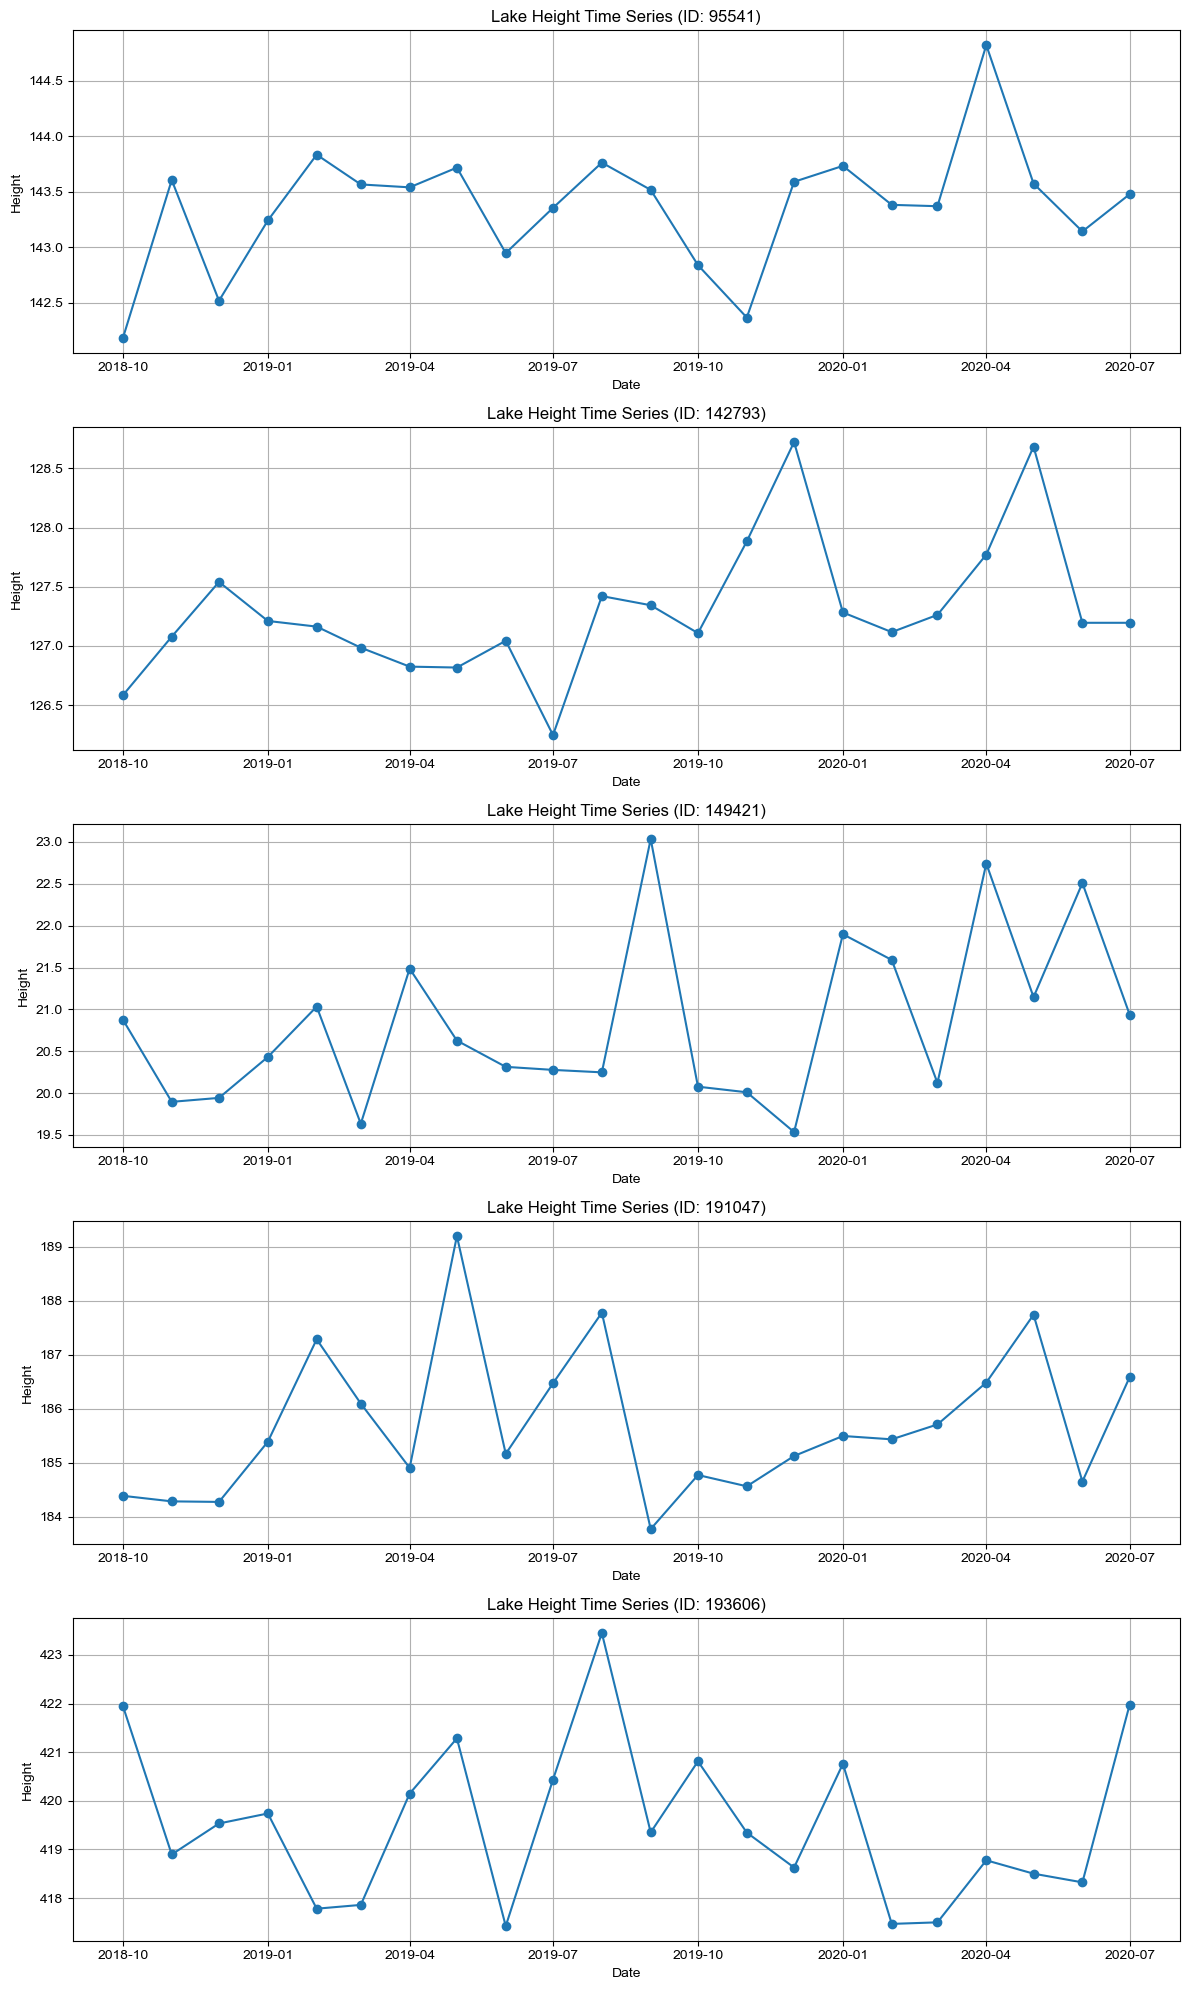

In [35]:

month_cols = df_cleaned.columns[5:]

time_data = pd.to_datetime(month_cols, format='%b%Y')

df_to_plot = df_cleaned.head(5)
num_plots = len(df_to_plot)
print(f"准备为 {num_plots} 个湖泊绘制图表...")

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, num_plots * 4))
if num_plots == 1:
    axes = [axes]

for ax, (index, lake_row) in zip(axes, df_to_plot.iterrows()):
    
    
    lake_id = lake_row['id']
    height_data = lake_row[month_cols]
    

    ax.plot(time_data, height_data, marker='o', linestyle='-')
    
    ax.set_title(f'Lake Height Time Series (ID: {lake_id})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Height')
    ax.grid(True)


plt.tight_layout()
plt.show()

In [36]:

info_cols = df_cleaned.iloc[:, :5]
month_cols_names = df_cleaned.columns[5:]
month_data_cleaned = df_cleaned[month_cols_names]
month_data_original = df_lakes[month_cols_names].apply(pd.to_numeric, errors='coerce')

stats_df = pd.DataFrame(index=df_cleaned.index)

stats_df['Max'] = month_data_cleaned.max(axis=1)
stats_df['Min'] = month_data_cleaned.min(axis=1)
stats_df['Mean'] = month_data_cleaned.mean(axis=1)
stats_df['Median'] = month_data_cleaned.median(axis=1)
stats_df['Std_Dev'] = month_data_cleaned.std(axis=1)


stats_df['Valid_Count'] = month_data_original.count(axis=1)

def calculate_slope(row_with_nans):
    # 将行数据转为 numpy 数组
    y = row_with_nans.values
    x = np.arange(len(y))
    
    # 创建一个 "遮罩" (mask)，只选择非NaN的数据
    mask = ~np.isnan(y)
    
    # 如果有效数据点少于2个，无法计算斜率
    if np.sum(mask) < 2:
        return np.nan
        
    x_masked = x[mask]
    y_masked = y[mask]
    
    # np.polyfit(x, y, 1) 会返回 [斜率, 截距]
    # 我们只取 [0] (即斜率)
    slope, intercept = np.polyfit(x_masked, y_masked, 1)
    
    return slope


stats_df['Avg_Month_Change'] = month_data_original.apply(calculate_slope, axis=1)
final_output = pd.concat([info_cols, stats_df], axis=1)
print(final_output)

            id   Latitude   Longitude           Area       Type          Max  \
95540    95541  66.170349 -123.098793   22622.509073    Natural   144.823421   
142792  142793  61.623337 -114.189430   26039.404469    Natural   128.722741   
149420  149421  60.752140   31.949997   17116.098144  Reservoir    23.034639   
191046  191047  53.086105  -98.453865   24827.936811  Reservoir   189.195905   
193605  193606  52.548405  106.370277   31951.020835  Reservoir   423.451042   
207673  207674  47.537960  -87.010521   70418.379664  Reservoir   147.434461   
208715  208716  46.965714  -91.424416   11451.130547  Reservoir   154.541555   
209353  209354  46.598183   76.393738   16544.870734    Natural   295.824089   
211174  211175  45.478054  -83.532387  116096.987982  Reservoir   140.626729   
213100  213101  43.720364  -77.652008   19230.172780  Reservoir    39.354362   
213962  213963  42.009071  -81.920372   21434.902813    Natural   138.961023   
222417  222418  -1.181953   33.516998   